In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import itertools
from scipy.stats import norm
from scipy.linalg import cholesky, cho_solve
import matplotlib.pyplot as plt


# 归一化的utils函数
def mean_variance_scaler_custom(x):
    x_array = np.array(x)
    mean = np.mean(x_array)
    std = np.std(x_array)
    scaled_x = (x_array - mean) / std
    return scaled_x

# 定义核函数
def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

    P1  P2  P3  P4      σ  Capacity  ESW(＞4.9 V)
0    2   3   1   5   1.10     58.20            1
1    2   2   3   7   1.50      0.00            0
2    3   1   4   6   0.84      0.00            0
3    2   4   5   1   0.00      0.00            0
4    1   3   2   2   3.70      5.70            1
5    1   2   1   4   0.64     54.73            1
6    3   1   6   3   0.00      0.00            0
7    1   3   2   3   4.80      0.00            0
8    2   3   1   4   0.82     43.13            1
9    1   3   1   4   1.35     63.60            1
10   1   3   1   5   2.43     62.48            1
11   1   4   1   5   3.61     63.78            1
12   1   3   2   5  12.55      0.00            0
13   1   2   1   5   1.27     48.58            1
[[2 3 1 5]
 [2 2 3 7]
 [3 1 4 6]
 [2 4 5 1]
 [1 3 2 2]
 [1 2 1 4]
 [3 1 6 3]
 [1 3 2 3]
 [2 3 1 4]
 [1 3 1 4]
 [1 3 1 5]
 [1 4 1 5]
 [1 3 2 5]
 [1 2 1 5]]
Top 4 points with highest EI values:
     P1  P2  P3  P4      mean  variance  contained_before        ei      

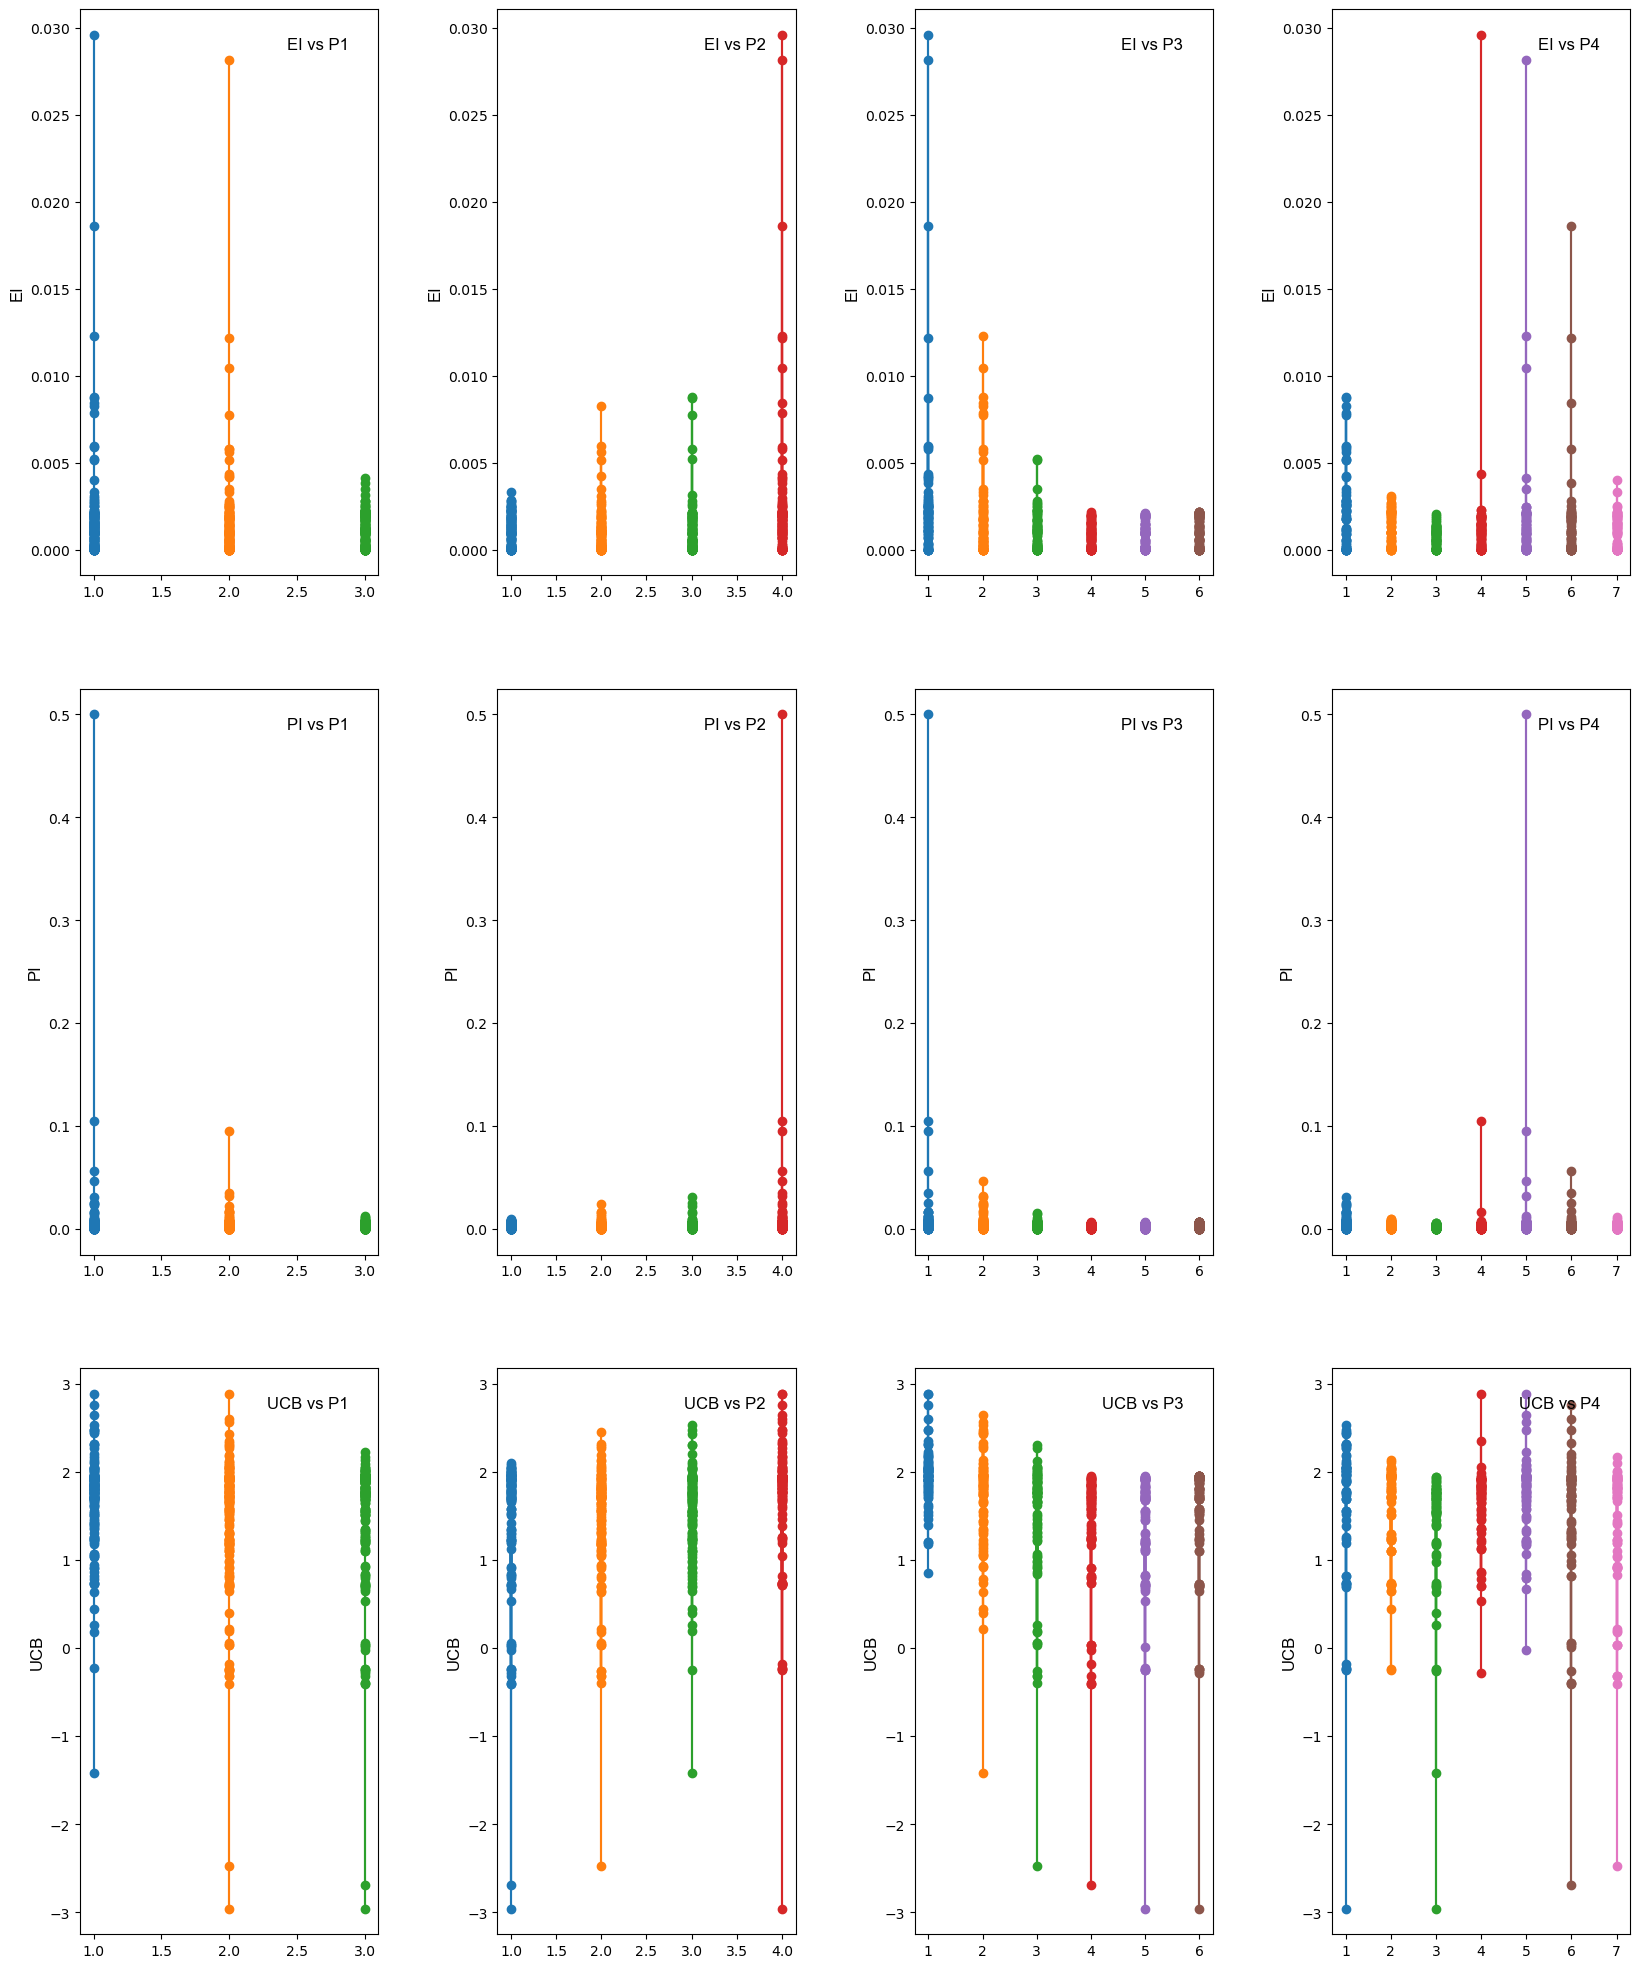

In [101]:
# 手动实现高斯过程回归
class CustomGaussianProcessRegressor:
    def __init__(self, kernel, alpha=1e-10):
        self.kernel = kernel
        self.alpha = alpha
        self.L_ = None
        self.alpha_ = None
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X_train, y_train):
        self.X_train_ = X_train
        self.y_train_ = y_train
        K = self.kernel(X_train, X_train)
        K[np.diag_indices_from(K)] += self.alpha
        self.L_ = cholesky(K, lower=True)
        self.alpha_ = cho_solve((self.L_, True), y_train)

    def predict(self, X_test):
        K_trans = self.kernel(X_test, self.X_train_)
        y_mean = np.dot(K_trans, self.alpha_)
        v = cho_solve((self.L_, True), K_trans.T)
        y_var = self.kernel(X_test, X_test) - np.dot(K_trans, v)
        return y_mean, y_var

    def sample_y(self, X_test, n_samples=1, random_state=None):
        y_mean, y_var = self.predict(X_test)
        rng = np.random.default_rng(random_state)
        y_samples = rng.multivariate_normal(y_mean.ravel(), y_var, n_samples).T
        return y_samples

class BayesOptCustom:
    def __init__(self, data_path):
        self.data_path = data_path
        self.params = None
        self.targets = None
        self.new_targets = None
        self.model = None
        self.all_points = None
        self.results = None
        self.kernel = rbf_kernel
        
        self._load_data()

    def _load_data(self):
        data = pd.read_excel(self.data_path, header=0)
        print(data)
        self.params = data.iloc[:, :4].values
        self.targets = data.iloc[:, 4:].values

    def _prepare_data(self): 
        coductivity_std = mean_variance_scaler_custom(self.targets[:, 0])
        capacity_std = mean_variance_scaler_custom(self.targets[:, 1])
        esw_std = mean_variance_scaler_custom(self.targets[:, 2])
        object  = coductivity_std+capacity_std+esw_std
        DataFrame(object).to_csv("objective_norm.csv",index = False)
        
        
        self.new_targets = (coductivity_std + capacity_std + esw_std).reshape(-1, 1)

    def _define_search_space(self):
        domain1 = np.arange(self.params[:, 0].min(), self.params[:, 0].max() + 1, 1)
        domain2 = np.arange(self.params[:, 1].min(), self.params[:, 1].max() + 1)
        domain3 = np.arange(self.params[:, 2].min(), self.params[:, 2].max() + 1)
        domain4 = np.arange(self.params[:, 3].min(), self.params[:, 3].max() + 1, 1)
        self.all_points = np.array(list(itertools.product(domain1, domain2, domain3, domain4)))

    def _define_model(self):
        self.model = CustomGaussianProcessRegressor(kernel=self.kernel)
        self.model.fit(self.params, self.new_targets)

    def _predict_points(self):
        means, variances = self.model.predict(self.all_points)
        self.results = pd.DataFrame(self.all_points, columns=['P1', 'P2', 'P3', 'P4'])

        self.results['mean'] = means
        self.results['variance'] = variances.diagonal()
        
        self.best_value = self.new_targets.max()

    def compute_entropy(self, p):
        return -p * np.log(p + 1e-9)
    def expected_improvement(self, mean, std, best):
        z = (mean - best) / std
        ei = (mean - best) * norm.cdf(z) + std * norm.pdf(z)
        return ei

    def probability_improvement(self, mean, std, best):
        z = (mean - best) / std
        pi = norm.cdf(z)
        return pi

    def upper_confidence_bound(self, mean, std, kappa):
        ucb = mean + kappa * std
        return ucb

    def thompson_sampling(self, n_samples=1, seed=None):
        sampled_functions = self.model.sample_y(self.all_points, n_samples=n_samples, random_state=seed)
        best_points = np.argmax(sampled_functions, axis=0)
        return self.all_points[best_points]

    def post_process(self):
        # self.results["contained_before"] = self.results.apply(lambda row: list(row[:4]) in self.params, axis=1)
        self.results["contained_before"] = self.results.apply(lambda row: [int(x) for x in row[:4]] in [[int(x) for x in sublist] for sublist in self.params], axis=1)

        print(self.params)
        self.results['ei'] = self.expected_improvement(self.results['mean'], np.sqrt(self.results['variance']), self.best_value)
        self.results['pi'] = self.probability_improvement(self.results['mean'], np.sqrt(self.results['variance']), self.best_value)
        self.results['ucb'] = self.upper_confidence_bound(self.results['mean'], np.sqrt(self.results['variance']), kappa=1.96)
        # self.results['es'] = self.entropy_search(self.results['mean'], np.sqrt(self.results['variance']), self.best_value, seed=42)
        self.results.to_excel("results1.xlsx", index=False)# 导出点和对应数据

        top_ei_points = self.results.nlargest(4, 'ei')
        top_pi_points = self.results.nlargest(4, 'pi')
        top_ucb_points = self.results.nlargest(4, 'ucb')
        #top_mean_points = self.results.nlargest(4, 'mean')
        #top_var_points = self.results.nsmallest(4, 'variance')
        # top_es_points = self.results.nlargest(4, 'es')
        thompson_points = self.thompson_sampling(n_samples=4, seed=410)

        print("Top 4 points with highest EI values:")
        print(top_ei_points)
        
        print("Top 4 points with highest PI values:")
        print(top_pi_points)
        
        print("Top 4 points with highest UCB values:")
        print(top_ucb_points)
        """
        print("Top 4 points with highest Mean values:")
        print(top_mean_points)
        print("Top 4 points with lowest variance values:")
        print(top_var_points)
        """
        # print("Top 4 points with highest ES values:")
        # print(top_es_points)
        
        print("Points selected by Thompson Sampling:")
        #print(thompson_points)
        print("thompson_points",thompson_points)
        thompson_points_df=DataFrame(thompson_points)
        thompson_points_df.columns = ["P1","P2","P3","P4"]
        thompson_points_df['weight'] = [4,3,2,1]
        print(top_ei_points[["P1","P2","P3","P4"]])
        print(top_pi_points[["P1","P2","P3","P4"]])
        print(top_ucb_points[["P1","P2","P3","P4"]])
        top_ei_points['weight'] = [4,3,2,1]
        top_pi_points['weight'] = [4,3,2,1]
        top_ucb_points['weight'] = [4,3,2,1]
        object_function_results = pd.concat([top_ei_points[["P1","P2","P3","P4","weight"]],top_pi_points[["P1","P2","P3","P4","weight"]],top_ucb_points[["P1","P2","P3","P4","weight"]],thompson_points_df],axis = 0)
        #object_function_results.to_csv("object_function_results.csv",index = False)
        object_function_results["category"] = object_function_results["P1"].astype(str)+object_function_results["P2"].astype(str)+object_function_results["P3"].astype(str)+object_function_results["P4"].astype(str)
        print(object_function_results["category"])
        print("count",object_function_results.groupby("category")["category"].count())
        object_function_df = object_function_results.groupby("category", as_index = False)["weight"].sum()
        object_function_df = object_function_df.sort_values("weight")
        object_function_df["count"] = DataFrame(object_function_results.groupby("category", as_index = False)["category"].count())
        #print(object_function_results)
        object_function_results.to_csv("object_function_results.csv",index = False)
        object_function_df.to_csv("object_function_df.csv",index = False)
        
        
        fig, axs = plt.subplots(3, 4, figsize=(20, 25))
        metrics = ['ei', 'pi', 'ucb']
        parameters = ['P1', 'P2', 'P3', 'P4']

        for i, metric in enumerate(metrics):
            for j, param in enumerate(parameters):
                unique_values = np.unique(self.results[param])
                for unique_value in unique_values:
                    subset = self.results[self.results[param] == unique_value]
                    axs[i, j].plot(subset[param], subset[metric], marker='o')
                
                axs[i, j].set_ylabel(metric.upper(), fontsize=12, fontname='Arial')
                axs[i, j].text(0.9, 0.95, f'{metric.upper()} vs {param}', 
                            horizontalalignment='right', 
                            verticalalignment='top', 
                            transform=axs[i, j].transAxes, 
                            fontsize=12, fontname='Arial')

        plt.subplots_adjust(wspace=0.4)
        plt.show()

    def run(self):
        self._prepare_data()
        self._define_search_space()
        self._define_model()
        self._predict_points()
        self.post_process()
        
bayes_opt = BayesOptCustom('第一次贝叶斯优化_YW.xlsx')
bayes_opt.run()